In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Introduction
The goal of this notebook is to examine ways to reduce exposure of crypto (mainly ETH and BTC) assets we are naturally long and looking to decrease/remove deltas. This notebook will compare various exchanges and methods to short these assets, focusing primarily on the differences between costs and capital efficiency.

This notebook will be split into a few sections:
<ol>
  <li>Introduction on perps</li>   
  <li>Introduction to various derivative exchanges</li>   
  <li>Cost of Hedging</li>   
  <li>Liquidations and Leverage</li>   
</ol>

## 1. Bitmex Perp
There are two primary methods to hedge long exposure, perpetual futures and quarterly futures. Quarterlies were first offered as a way for miners to hedge their exposure as it would lock in a price much like the commodities markets on CME. However, the speculators hated the quarterlies, because it was primarily made up of retail participants who did not want to roll and the leverage was not too high.

Enter the perpetual future from Bitmex which solves both of these issues by [popularizing](https://blog.bitmex.com/announcing-the-launch-of-the-perpetual-xbtusd-leveraged-swap/) the perpetual swap. Within no time, the perpetual swap overtook the spot and quarterly market in terms of volume and is still the dominate product that settles the large majority of trades today[<sup>1</sup>](#fn1). 

The key innovation is that there is a funding rate (paid every 8 hours) to make sure the market price does not deviate too far from the index price of the asset. If the market price is greater than the index price, the longs pay the shorts (encouraging the price to go down) and vice versa. More specific details and formulas on how the funding rate is determined by the various exchanges can be found [here](https://bobekryant.github.io/perp-funding.html).


In [2]:
import pandas as pd
import numpy as np
import requests
import json
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import os
import pytz
import pull_ftx_hedging_data
import warnings
from fitter import Fitter
import scipy.stats

warnings.filterwarnings("ignore")

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,'data')
tickers = ['BTC','ETH']

## 2. Examining the Exchange Options
Below is a [picture](https://www.coingecko.com/en/exchanges/derivatives) of the largest derivatives exchanges. These exchanges do massive volume and are exceedingly lucrative and liquid. By in large they are pretty similar, but each have their own nuances with product structures and how they do leverage and liquidation.

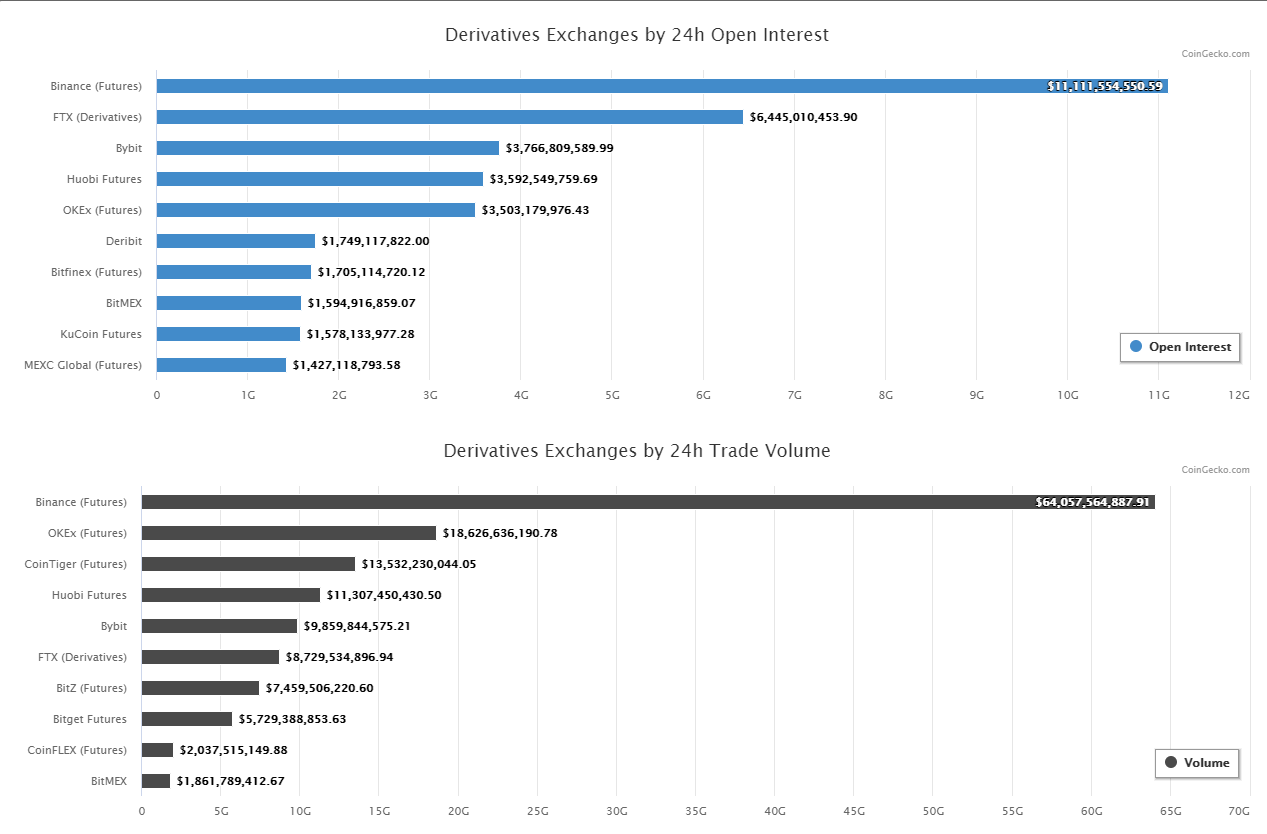

Binance was founded in 2017 at the start of the previous cycle and it is by far the largest exchange with the most volume and open interest. Next on the list are the two fastest growing exchanges FTX (2019) and Bybit (2018). Binance and FTX each have over 100 perps, listing many altcoins and quarterlies as well as perps. Bybit has taken the opposite approach, focusing on routing all liquidity to a few of the major perps and with little emphasis on altcoins and quarterlies. In addition, the majority of Bybit volume involves inverse futures. Rounding out the top 5 are Huobi and OKEx two popular Chinese exchanges which have been adversely impacted by the CCP crackdown on Crypto trading. OKEx has had its founder [arrested](https://www.forbes.com/sites/kenrapoza/2020/10/16/chinese-ceo-of-okex-crypto-exchange-arrested-again-whales-bail)
and froze [withdraws](https://www.coindesk.com/okex-to-resume-withdrawals-before-nov-27-offers-new-compensation-programs) for 5 weeks. Finally, Deribit stands out in this list as it is an options platform while the others are all futures. 

#### 2.1 Binance
Binance has a very [aggressive](https://www.binance.com/en/support/faq/360033525271) liquidation system which can lead to [large wicks](https://www.cryptonary.com/journal/flash-crash-18-april-2021-whats-next/) and [flash crashes](https://www.coindesk.com/binance-controls-flash-crash-polkadot) because all liquidation orders are IOC market orders which can cause a cascading liquidation effect.

#### 2.2 FTX
FTX was founded on the motto "for traders by traders". Along with innovative product offerings, one of the major selling points is the world class risk management system with minimal claw-backs. There is a [three](https://help.ftx.com/hc/en-us/articles/360027668712-Liquidations) tiered liquidation step which helps reduce the flash crash wicks seen in Binance. The main difference is that FTX sends limit orders to help liquidate while Binance sends market orders.

#### 2.3 Bybit
Bybit positioned itself as the main BitMex competitor, because they both offer inverse contracts as opposed to the linear contracts of Binance and FTX. Volume here started picking up after the BitMex founders were [charged](https://www.bloomberg.com/news/articles/2020-10-01/bitmex-founders-and-executives-are-indicted-in-new-york) by the US Regulators. Bybit [uses](https://help.bybit.com/hc/en-us/articles/900000167723-Liquidation-Process-USDT-Contract) a similar liquidation system to Binance with Fill or Kill market orders once an account is below the maintenance margin. 

#### 2.4 Other Exchanges
I suggest not trading on the exchanges with close China ties, especially if the exchange has gated withdraws before. There are some other popular exchanges like Bitfinex and Kucoin, but those have both been hacked before and gated withdraws for a while until their insurance covered the losses. A more detailed post, analysis can be expanded to the other exchanges in the top 10, but this notebook will focus on the 3 largest exchanges that have had relatively few issues Binance, FTX, and Bybit.

## 3. Cost of hedging
Below, we see cumulative funding on BTC and ETH perps and its interesting how Bybit is so much higher both Binance and FTX. This means that all things equal, we can collect the most amount of funding shorting Bybit[<sup>2</sup>](#fn2). Bybit and Binance both have a built in .01% funding rate over 8 hours, so it makes sense that both of them have higher cumulative funding than FTX. It also seems that the traders on Bybit are more agressive and want to be more long than the Binance speculators. Nonetheless, we get paid to hedge in a bull market and we will have to pay to hedge in a bear market. 

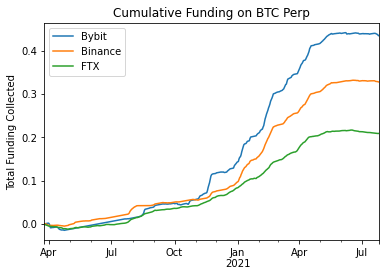

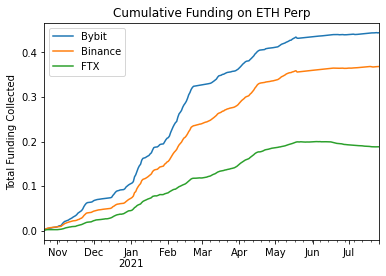

In [3]:
for ticker in tickers:
    bybit_data = pd.read_csv(os.path.join(data_dir,'bybit','funding',ticker+'USDT.csv'),index_col=0,parse_dates=[0])
    bybit_data.index = bybit_data.index.tz_localize('UTC')
    binance_data = pd.read_csv(os.path.join(data_dir,'binance','funding',ticker+'USDT.csv'),index_col=0,parse_dates=True)
    binance_data.index = binance_data.index.tz_localize('UTC')
    ftx_data = pd.read_csv(os.path.join(data_dir,'ftx','funding',ticker+'-PERP.csv'),index_col=0,parse_dates=True)
    daily_funding = pd.concat([bybit_data['Funding Rate'].resample('1D').sum(), binance_data['fundingRate'].resample('1D').sum(),ftx_data['rate'].resample('1D').sum()],axis=1)
    daily_funding.columns = ['Bybit','Binance','FTX']
    daily_funding.dropna(inplace=True)
    daily_funding.cumsum().plot()
    plt.title('Cumulative Funding on ' + ticker +' Perp')
    plt.ylabel('Total Funding Collected')
    plt.show()

#### 3.1 Perp versus Quarterly Future
Below we can compare the FTX perp with the front quarter future and the plots below show the pnl of shorting the respective futures. For our purposes, were we short, we should probably use the perps as they typically have a higher rate return compared to the quartiles and we would not need to roll these, further reducing our fees. Vice versa if we were looking for long exposure, I would suggest bidding the quartiles instead of the perpetuals as they are cheaper funding wise. 

In [4]:
funding_dict = {}
index_dict = {}
quarterly_dict = {}
for ticker in tickers: 
    perp_funding_frame = pull_ftx_hedging_data.get_perp_funding(ticker+'-PERP')
    index_price = pull_ftx_hedging_data.get_historical_price(ticker, index=True)
    index_price.rename({'close':'index'},axis=1,inplace=True)
    quarterly_frame = pull_ftx_hedging_data.get_quarterly_funding(index_price, ticker)
    quarterly_funding_frame = pull_ftx_hedging_data.get_active_quarterly_funding(quarterly_frame)

    funding_frame = pd.merge(perp_funding_frame[['Perp']],quarterly_funding_frame[['F1']],left_index=True,right_index=True)
    funding_dict[ticker] = funding_frame
    index_dict[ticker] = index_price
    quarterly_dict[ticker] = quarterly_frame


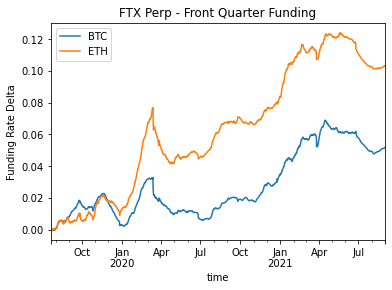

In [5]:
temp_list = []
for ticker in tickers:
    temp_diff = (funding_dict[ticker]['Perp']-funding_dict[ticker]['F1'])
    temp_list.append(temp_diff)
temp_list = pd.concat(temp_list,axis=1)
temp_list.columns = tickers

temp_list.cumsum().plot()
plt.title('FTX Perp - Front Quarter Funding')
plt.ylabel('Funding Rate Delta')
plt.show()


#### 3.2 Mixing Perp and Quarterly Strategy
There is a way to squeeze out even more juice from the funding rate if we can successfully time when the perp will have higher funding or the quarterly. The perpetual future funding rate can be thought of as a rapidly changing proxy for how bullish/bearish the speculators are feeling at this moment, while the quarterly future funding rate is a prediction on how the speculators will feel at expiry. This causes the perpetual future funding rate to have a lot more swings then its quarterly counter party and we can see this in the plot below which shows the rolling annualized funding rate for those days. 

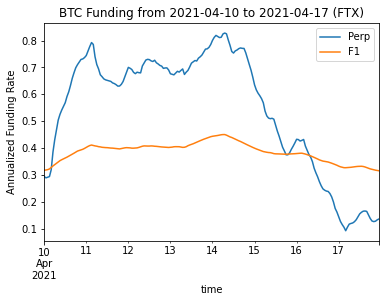

In [6]:
ticker = 'BTC'
start_date = '2021-04-10'
end_date = '2021-04-17'
(funding_dict[ticker].rolling(24).sum()[start_date:end_date]*365).plot()
plt.title(ticker + ' Funding from '+ start_date + ' to ' + end_date +' (FTX)')
plt.ylabel('Annualized Funding Rate')
plt.show()

Here in mid April, we have the quarterly sitting at almost 40% APR[<sup>3</sup>](#fn3), over twice the historical average. By shorting the future at that exact moment, we can lock in the funding rate for the rest of the quarter (until 6/25). Here is the comparison to the perpetual future for the rest of the quarter and we can see the market for BTC cooled off afterwards so the perpetual future funding ended up a lot lower than the quarterly funding rate.

In [7]:
lock_date = '2021-04-11 00:00'
ticker = 'BTC'
temp_funding = funding_dict[ticker][lock_date:'2021-06-26'][['Perp']]
temp_funding['F1'] = funding_dict[ticker].loc[lock_date]['F1']

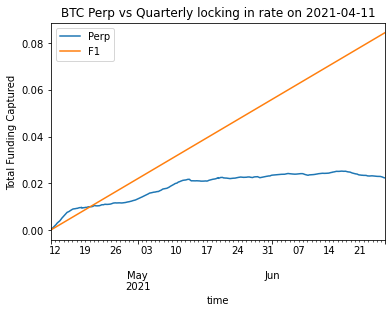

In [8]:
temp_funding.cumsum().plot()
plt.title(ticker + ' Perp vs Quarterly locking in rate on '+lock_date.split(' ')[0])
plt.ylabel('Total Funding Captured')
plt.show()

That is a cherry picked example just to show that it is possible to switch between the perp which usually pays out more and the quarterly where one can lock in the rate for the rest of the quarter if the projected perp funding rate is be lower afterwards. There are a few basic rules that we can follow to create a baseline model like "Lock in quarterly rate if it is 2x higher than the average historical perp funding rate of the 10-15%." Other more advanced models could look at additional factors like time till expiry, other further out months, other asset funding rates, as well as other exchange funding rates.

Below we have a simple model that locks in the rate if the current perp funding rate if it is less than the rolling weekly perp rate (signaling a more bearish regime) and the future rate is more than 15% else we use the perp rate. We compare the results to a strategy that shorts only the perp or one that shorts only the quarterly and see that the mixed result is superior.

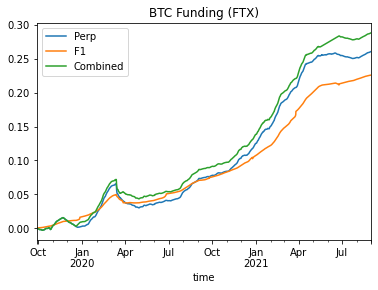

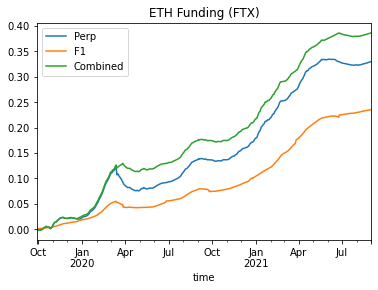

Total Funding Collected
            BTC    ETH
Perp      0.261  0.330
F1        0.226  0.236
Combined  0.289  0.387


In [9]:
lock_in_rate = .15
rolling_lookback = 7*24
btc_funding_full, btc_expiry_stats = pull_ftx_hedging_data.combine_funding_strats(quarterly_dict,funding_dict,'BTC',lock_in_rate,rolling_lookback)
btc_funding_full[['Perp','F1','Combined']].cumsum().plot()
plt.title('BTC Funding (FTX)')
plt.show()

eth_funding_full, eth_expiry_stats = pull_ftx_hedging_data.combine_funding_strats(quarterly_dict,funding_dict,'ETH',lock_in_rate,rolling_lookback)
eth_funding_full[['Perp','F1','Combined']].cumsum().plot()
plt.title('ETH Funding (FTX)')
plt.show()

total_funding = pd.concat([btc_funding_full[['Perp','F1','Combined']].sum(),eth_funding_full[['Perp','F1','Combined']].sum()],axis=1)
total_funding.columns = ['BTC','ETH']
print('Total Funding Collected')
print(total_funding.round(3))

#### 3.3 Trading Fees
[Binance](https://www.binance.com/en/fee/futureFee), [FTX](https://help.ftx.com/hc/en-us/articles/360024479432-Fees), and [Bybit](https://help.bybit.com/hc/en-us/articles/360039261154-Taker-s-Fee-and-Maker-s-Rebate-Calculation) all have slightly different trading fees and discounts associated with cutting down those fees. Here is the default trading fees for all three exchanges:

|         	| Taker  	| Maker   	| Total 	|
|---------	|--------	|---------	|-------	|
| Binance 	| 0.04%  	| 0.02%   	| .06%  	|
| FTX     	| 0.07%  	| 0.02%   	| .09%  	|
| Bybit   	| 0.075% 	| -0.025% 	| .05%  	|

We see that Bybit has the lowest total fees, but Binance and FTX fees actualy vary by trading volume and both have their own coin exchange coin BNB and FTT respectively. Holding/staking these coins can drop the amount of fees substantially[<sup>4</sup>](#fn4). 

#### 3.4 Margin and Collateral
There is no extra fee to pay for using margin and almost every coin can be used as collateral, but the non-USD coins will count as a fraction of their actual worth. For instance (on [FTX](https://help.ftx.com/hc/en-us/articles/360027946371-Margin-Collateral)), 1 dollar in BTC counts as .975 dollars of collateral, while 1 dollar in ETH counts as .95 dollars of collateral. The borrow/lend rate for spot gets baked into the funding rate for futures.

#### 3.5 Examples
Here is how much putting on a 1k, 10k, and 100k USD position in BTC costs for the first 6 months of 2021[<sup>5</sup>](#fn5). We assume trading on FTX and limit orders to enter and exit our perp positions[<sup>6</sup>](#fn6). The cost calculation would be:

$$
Cost = EntryFee + ExitFee + Funding\\
$$

In the example below, cost scales perfectly with size. Depending on slippage, trading more size can actually be more cost effective because of higher volume benefits

In [10]:
btc_perp = pd.read_csv(os.path.join(data_dir,'ftx','BTC-PERP.csv'),index_col=1,parse_dates=True)['2021-01-01':'2021-06-30']
btc_perp_funding_frame = pd.read_csv(os.path.join(data_dir,'ftx','funding','BTC-PERP.csv'),index_col=0,parse_dates=True)['2021-01-01':'2021-06-30']


In [11]:
port_sizes = [1000, 10000, 100000]
cost_frame = []
for port_size in port_sizes:
    temp_cost = pull_ftx_hedging_data.get_hedging_costs(btc_perp, btc_perp_funding_frame, port_size=port_size, fee = .02*.01)
    cost_frame.append(temp_cost)
print('Size of Wallet in USD vs First 6 months hedging profits')
print(pd.Series(cost_frame , index = port_sizes))


Size of Wallet in USD vs First 6 months hedging profits
1000        225.673
10000      2256.729
100000    22567.295
dtype: float64


## 4. Optimal Leverage and Liquidation
Binance and FTX have recently reduced leverage from 100x to 20x while Bybit still allows 100x, however these leverage ratios are just asking to be liquidated. Below is a conservative[<sup>7</sup>](#fn7) liquidation calculator which shows us the percent change from initial that we would get liquidated on, so a 1x leverage short would need to go around 94% against us to get liquidated while a 10x move only needs around 7% against us.

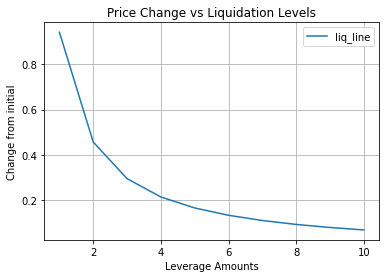

In [12]:
balance = 10000
initial_price = 10000
liq_dict = {}
maintenance_margin = .03
for i in range(1,11):
    liq_price = pull_ftx_hedging_data.get_liq_price(initial_price, i, balance, maintenance_margin)
    liq_dict[i] = (liq_price/initial_price)-1

liq_frame = pd.DataFrame.from_dict(liq_dict, orient='index', columns=['liq_line'])
liq_frame.plot()
plt.title('Price Change vs Liquidation Levels')
plt.xlabel('Leverage Amounts')
plt.ylabel('Change from initial')
plt.grid()
plt.show()

#### 4.1 Largest Historical Moves 
Due to being delta neutral, but on different exchanges, any large volatility movement we need to hold out to have enough time to move assets from one wallet (long spot) to another (short futures). One of the more important parameters (assumptions) is the time that it takes to move these assets which has been set to 15 minutes. The time varies depending on the blockchain and the state of the network; 15 minutes is on the extremely long end for the Etherum network[<sup>8</sup>](#fn8). Also, we should also be able to cut  down the time using different networks such as sending USDT on the TRX network. 

It is worth noting that we are shorting these positions and nukes typically occur on the short side as opposed to the long side. Using OHLC candles (from early 2019 when the data starts), we can look at the high and the low to account for any sort of wicks. The only 15% or more moves in 15 minutes to the upside happened around 2020-03-12 and then again on 2021-05-19. This was after large 25-30% nukes to the downside, so we would have been heavily profitable on our short position with no real need to transfer money in. Through this quick study, we can see that the optimal leverage should be different for longs and shorts as upside volatility is less than downside volatility. 

This liquidation/leverage amount should not be static, but as a minimum baseline if we use 3x leverage there would need a around a 29% move against us to get liquidated. This is over twice as much as the largest historical drawdown since our data started[<sup>9</sup>](#fn9). If we were longing, a 2x - 2.5x leverage is more apt as there have been 25% drawdowns on the short end.

#### 4.2 Theoretical Distributions
The most difficult part in building models is that these large jumps do not occur that often[<sup>10</sup>](#fn10). For our FTX BTC-PERP dataset which is around 2 years, we can calculate largest move in either direction for 15 minute rolling periods and fit that into various distributions. We  then take the fitted distribution and calculate probability of X move and reverse that to get what leverage we can use. 

In [13]:
rolling_window = 15
btc_perp = pd.read_csv(os.path.join(data_dir,'ftx','BTC-PERP.csv'),index_col=1,parse_dates=True)#['2020':]
btc_perp['percent_change_rolling'] = btc_perp['close'].pct_change(periods=rolling_window)
btc_perp['percent_change_up'] = (btc_perp['high'].rolling(rolling_window).max()-btc_perp['close'])/btc_perp['close']
btc_perp['percent_change_down']= (btc_perp['low'].rolling(rolling_window).min()-btc_perp['close'])/btc_perp['close']
btc_perp['percent_change_max'] = np.maximum(btc_perp['percent_change_down'].abs(),btc_perp['percent_change_up'])
btc_perp['realized_vol'] = btc_perp['close'].pct_change().rolling(rolling_window).std()
btc_perp['realized_annual_vol'] = btc_perp['realized_vol'] * (1440/rolling_window) * 365**.5
btc_perp['realized_annual_vol_lag'] = btc_perp['realized_annual_vol'].shift(rolling_window)


In [14]:
print('Distribution Summary: Change in 15 Minutes')
perp_dist_stats = btc_perp['percent_change_max'].describe()[['mean', 'std', 'min', '25%', '50%', '75%']]
perp_dist_stats['99%'] = btc_perp['percent_change_max'].quantile(.99)
perp_dist_stats['99.9%'] = btc_perp['percent_change_max'].quantile(.999)
perp_dist_stats['99.99%'] = btc_perp['percent_change_max'].quantile(.9999)
perp_dist_stats['99.999%'] = btc_perp['percent_change_max'].quantile(.99999)
perp_dist_stats['Max'] = btc_perp['percent_change_max'].max()
(pd.DataFrame(perp_dist_stats).T.round(3)*100)

Distribution Summary: Change in 15 Minutes


,mean,std,min,25%,50%,75%,99%,99.9%,99.99%,99.999%,Max
percent_change_max,0.4,0.4,0.0,0.2,0.3,0.5,2.0,4.7,10.7,19.1,24.9


There are a many popular distributions we can fit to our dataset, but because we only care about the right tail, most of the classical metrics like sum of square errors and aic are not that good at picking the proper distribution. Because of this, we can only focus on the outliers in the dataset. For instance, we compare the normal distribution with more skewed distributions (like the Gamma and power distributions for the extreme right tail), for events above 5% delta in 15 minutes otherwise known as the 99.9%.

We use a package in Python which iterates 50 different distributions to compare the histogram of the data to the various known distributions. From that iteration we choose a top distribution [(log normal)](https://en.wikipedia.org/wiki/Log-normal_distribution), a unique distribution [(power)](https://en.wikipedia.org/wiki/Power_law), and the default normal distribution which is unable to capture the long tails and one of the worst stats in the fitting department.

          sumsquare_error      bic
lognorm            408.09  -736.45
powerlaw          2659.98   997.55
norm              5421.21  1649.32


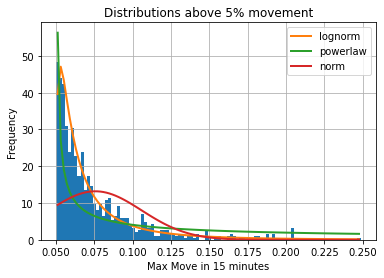

In [15]:
large_moves = btc_perp[btc_perp['percent_change_max']>.05]
f = Fitter(large_moves['percent_change_max'],distributions=['norm','lognorm','powerlaw'],timeout=50)
f.fit()
print(f.summary()[['sumsquare_error','bic']].round(2))
plt.title('Distributions above 5% movement')
plt.xlabel('Max Move in 15 minutes')
plt.ylabel('Frequency')
plt.show()

We can take a closer look at the qq distribution to see how good a fit we have. Looking at the lognorm distribution, we see a really tight fit until the end with the ordered values above .2. This means that at the extreme tail end, the lognorm underestimates the true values. The opposite is the case for the powerlaw which ramps up the delta between the distribution values and what the data actually shows. Averaging out a few of these models could be an interesting concept to explorer further.

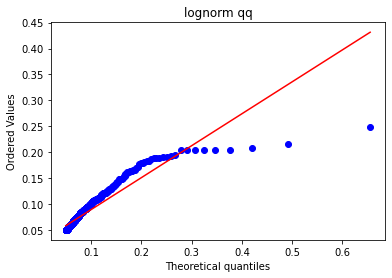

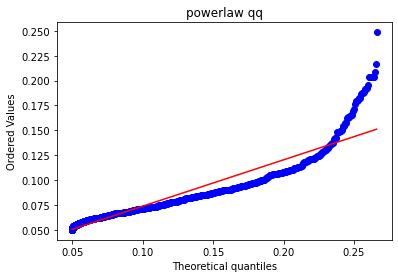

In [16]:
res = scipy.stats.probplot(large_moves['percent_change_max'],sparams = f.fitted_param['lognorm'], plot=plt,dist = scipy.stats.lognorm)
plt.title('lognorm qq')
plt.show()

res = scipy.stats.probplot(large_moves['percent_change_max'],sparams = f.fitted_param['powerlaw'], plot=plt,dist = scipy.stats.powerlaw)
plt.title('powerlaw qq')
plt.show()

Taking it a step further, we can look at at the normal, lognormal and power model across various realized volatility buckets: bottom 25% of realized vol, 25-50% of realized vol, 50-75% of realized vol and 75% plus of realized vol. For the bottom 25% of realized vol we see that lognormal has the lowest sum of squared errors and aic, which makes sense based on what we saw above.

We can use the inverse CDF to see what the largest move[<sup>11</sup>](#fn11) in 15 minutes is for this volatility bracket. The normal distribution outputs 1% for this volatility bracket while the Gamma and power distributions predict moves magnitudes higher as they have fatter tails.

In [17]:
realized_vol_sum = btc_perp['realized_annual_vol_lag'].describe()
temp_frame = btc_perp[btc_perp['realized_annual_vol_lag']<realized_vol_sum['25%']].dropna()
f = Fitter(temp_frame['percent_change_max'],distributions=['norm','lognorm','powerlaw'])
f.fit()

          sumsquare_error         bic
lognorm           1008.12 -1543593.50
norm             77121.24  -350034.92
powerlaw        236277.57   -41914.08


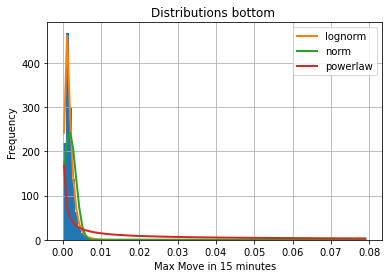

In [18]:
print(f.summary()[['sumsquare_error', 'bic']].round(2))
plt.title('Distributions bottom ')
plt.xlabel('Max Move in 15 minutes')
plt.ylabel('Frequency')
plt.show()

In [19]:
projected_moves = pd.DataFrame(index=['Norm','LogNorm','Power'],columns = ['25%','50%','75%','100%'])
print('Largest Projected Move (for next 15 minutes) when Realized Vol is in bottom 25%')
val = .9999999
param = f.fitted_param['norm']
dist = scipy.stats.norm
print('Normal distribution projected highest move: ' + str(dist.ppf(val,*param).round(3)*100) + '%')
projected_moves.loc['Norm','25%'] = dist.ppf(val,*param)

param = f.fitted_param['lognorm']
dist = scipy.stats.lognorm
print('LogNorm distribution projected highest move: ' + str(dist.ppf(val,*param).round(4)*100) + '%')
projected_moves.loc['LogNorm','25%'] = dist.ppf(val,*param)

param = f.fitted_param['powerlaw']
dist = scipy.stats.powerlaw
print('Power distribution projected highest move: ' + str(dist.ppf(val,*param).round(3)*100) + '%')
projected_moves.loc['Power','25%'] = dist.ppf(val,*param)

Largest Projected Move (for next 15 minutes) when Realized Vol is in bottom 25%
Normal distribution projected highest move: 1.0%
LogNorm distribution projected highest move: 3.61%
Power distribution projected highest move: 8.1%


In [20]:
distributions = [25,50,75]
for i,dist_num in enumerate(distributions):
    if dist_num == 75:
        temp_frame = btc_perp[(btc_perp['realized_annual_vol_lag']>realized_vol_sum['75%'])].dropna()
    else:
        temp_frame = btc_perp[(btc_perp['realized_annual_vol_lag']>realized_vol_sum[str(dist_num)+'%']) & (btc_perp['realized_annual_vol_lag']<realized_vol_sum[str(dist_num+25)+'%'])].dropna()
    f = Fitter(temp_frame['percent_change_max'],distributions=['norm','lognorm','powerlaw'])
    f.fit()

    param = f.fitted_param['norm']
    dist = scipy.stats.norm
    projected_moves.loc['Norm',str(dist_num+25)+'%'] = dist.ppf(val,*param)

    param = f.fitted_param['lognorm']
    dist = scipy.stats.lognorm
    projected_moves.loc['LogNorm',str(dist_num+25)+'%'] = dist.ppf(val,*param)

    param = f.fitted_param['powerlaw']
    dist = scipy.stats.powerlaw
    projected_moves.loc['Power',str(dist_num+25)+'%'] = dist.ppf(val,*param)
    


In [21]:
print('Largest Percent Moves in each Quantile')
(projected_moves.astype(float)*100).round(2)

Largest Percent Moves in each Quantile


,25%,50%,75%,100%
Norm,1.03,1.39,1.86,4.30
LogNorm,3.61,4.62,6.11,15.87
Power,8.11,8.30,9.57,25.55


After doing the same steps for the next three volatility buckets, we can translate our largest moves to a more dynamic leverage amount. However, I think the above distribution approach works better in theory than in practice and I am not fond of it, because we do not have enough data points at the tail end to simulate the proper distribution. A better step would also be to split the above analysis into buys and sells as I believe they have different volatility characteristics (but that decreases the datapoints even further).

That being said this is a decent improvement over the default model in section 4.1 where we had constant leverage. I would probably suggest a mixed model like the following:

\begin{cases} 
      \frac{LogNorm_x + Power_x}{2} +  \epsilon & x_{RealizedVol} \in (25, 50, 75)\\
      Power_x + \epsilon & x_{RealizedVol} \in (100) \\
\end{cases}

So if realized vol was in the 25%, then our projected max move in 15 minutes would be (3.61+8.11)/2 = 5.86% plus some epsilon for safety purposes which we can then go to our leverage plot and find the proper leverage amount.

#### 4.3 Model Improvement
We can use alternative data like open interest/volume, options, [move contracts](https://help.ftx.com/hc/en-us/articles/360033136331-MOVE-contracts), [liquidation levels](https://docs.thekingfisher.io/products/liquidations-maps)[<sup>12</sup>](#fn12), and the orderbook to adjust our leverage amount. 

It took a while to even pull daily open interest data, but we can see that on the days when BTC nukes, open interest goes down substantially. While this itself is a lagging indicator of price, perhaps the overall level of open interest combined with book depth can tell how overheated the market is, and how much unwinding a certain amount of crypto will impact the prices.

## 5. Conclusion
Here we have analyzed three of the largest crypto exchanges and the various pros and cons of each. In addition, we look at 2 models to hedge our crypto exposure, one with a constant leverage ratio and one with a more dynamic leverage ratio.

#### Footnotes
<span id="fn1">1. The perpetual futures on Binance have over 10x the open interest than the quarterlies.</span> <br>
<span id="fn2">2. I am unable to pull a longer historical funding rate from Bybit, thus truncating the lookback in the graphs below</span> <br>
<span id="fn3">3. APR to APY is technically hourly compounding for FTX and 8 hours for Binance and Bybit, but that needs to re-hedge with fees so its not a super clean calculation.</span> <br>
<span id="fn4">4. Staking 25 FTT will drop the maker fees to 0.</span> <br>
<span id="fn5">5. These positions will keep a constant BTC amount as opposed to a constant dollar amount. (I think constant BTC amount is easier to keep track of vs alternative) </span> <br>
<span id="fn6">6. Note that this does not take into account adding more collateral to the account in case the short blows out. </span> <br>
<span id="fn7">7. Values are from FTX, which start the liquidation process earlier than Binance and Bybit.</span> <br>
<span id="fn8">8. ETH2 upgrade to POS will speed up the block times and thus the confirmation times.</span> <br>
<span id="fn9">9. Although the data does not go back further, I do not think more data would be useful as I think the structure of the market has fundamentally changed and is very different pre-2019 versus post 2019. There are more institutional players and the entire DeFi ecosystem does not really exist pre-2020. Because Defi has large liquidity pools of spot with ETH-stable and BTC-Stable these are inherently unlevered and very hard to move prices, also slowing down large jump moves as arbitrageurs will come in and arb the centralized exchanges with the decentralized exchanges.</span> <br>
<span id="fn10">10. Although I do not believe upside volatility to be as large as downside volatility, we will combine them in this section. </span> <br>
<span id="fn11">11. I set the percentile for the inverse cdf to be .9999999.</span> <br>
<span id="fn12">12. I am not sure how they are calculating liquidation levels for this site but something similar would be useful to know the painpoints of cascading liquidations which ultimately lead to large jumps. Liquidation levels in defi can also be included as the ones in lending protocols (like MakerDao) are public.</span> <br>

